<a href="https://colab.research.google.com/github/Huxaifax/TensorFlow-/blob/main/pytorch_deepLearning_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
 import torch
 import numpy as np
 import torchvision
 from torchvision.datasets import MNIST
 from torchvision.transforms import ToTensor
 from torch.utils.data.sampler import SubsetRandomSampler
 from torch.utils.data.dataloader import DataLoader

In [42]:
dataset = MNIST(root='data/',
                download = True,
                transform=ToTensor())

In [43]:
img, label = dataset[0]

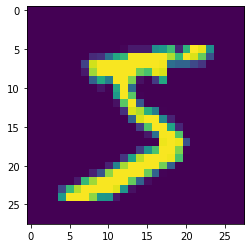

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img[0])

In [45]:
img[0,10:15,10:15]

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])

In [46]:
def split_indices(n,val_pct):
  n_val= int(val_pct*n)
  idxs = np.random.permutation(n)
  return idxs[n_val:], idxs[:n_val]

In [47]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

print(len(train_indices), len(val_indices))
print("Sample val indices", val_indices[:20])

48000 12000
Sample val indices [56348 16851 40634  2869  4657 31282 16626 53670 32501 39218 47098  2516
 26143 43900  2207 42960 38253 19981 34325 14002]


In [48]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler = train_sampler)

valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                      batch_size,
                      sampler = valid_sampler)

In [49]:
import torch.nn.functional as F
import torch.nn as nn

In [50]:
class MnistModel(nn.Module):

  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out 

In [51]:
input_size =784
num_classes =10

model = MnistModel(input_size, hidden_size=32,
                   out_size=num_classes)

In [52]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [53]:
for images, labels in train_dl:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('outputs shape: ', outputs.shape)
print('Sample Outputs :\n', outputs[:2].data)

Loss: 2.330378770828247
outputs shape:  torch.Size([100, 10])
Sample Outputs :
 tensor([[ 3.8827e-02, -1.7232e-01, -1.9226e-02,  4.2602e-02, -1.6929e-02,
          3.4530e-02, -1.7915e-01,  2.6994e-04, -2.3057e-01,  9.7485e-03],
        [ 1.6926e-02, -2.0365e-01,  9.3531e-02,  8.1424e-02, -4.2081e-02,
          8.2263e-02, -1.8002e-01, -5.1979e-02, -2.7590e-01,  5.0682e-02]])


Training on GPU


In [54]:
torch.cuda.is_available()

True

In [55]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [56]:
device = get_default_device()
device

device(type='cuda')

In [57]:
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return (to_device(x,device) for x in data)
  return data.to(device, non_blocking=True)

In [58]:
for images, labels in train_dl:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([100, 1, 28, 28])
cuda:0


In [59]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)
    

In [60]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [61]:
for xb, yb in valid_dl:
  print('xb.device', xb.device)
  print('yb', yb)
  break

xb.device cuda:0
yb tensor([2, 6, 3, 0, 4, 8, 4, 1, 8, 0, 4, 1, 0, 9, 0, 2, 8, 9, 8, 9, 0, 1, 4, 8,
        6, 8, 4, 2, 8, 2, 3, 1, 8, 4, 0, 2, 7, 0, 5, 8, 0, 9, 6, 3, 4, 8, 3, 7,
        0, 0, 3, 5, 8, 7, 4, 5, 5, 8, 6, 3, 9, 4, 6, 2, 2, 1, 5, 6, 7, 7, 3, 7,
        1, 6, 1, 4, 4, 4, 8, 9, 9, 3, 0, 6, 6, 1, 0, 0, 4, 2, 8, 3, 2, 1, 1, 7,
        3, 9, 8, 6], device='cuda:0')


Training model

In [76]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
  preds = model(xb)
  loss = loss_func(preds, yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  metric_result = None
  if metric is not None:
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result

In [77]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad():

    results= [loss_batch(model, loss_fn, xb, yb, metric=metric)
             for xb, yb in valid_dl]

    losses, nums, metrics = zip(*results)

    total = np.sum(nums)
    avg_loss = np.sum(np.multiply(losses,nums))/total
    avg_metric = None
    if metric is not None:
      avg_metric = np.sum(np.multiply(metrics, nums))/total
  return avg_loss, total, avg_metric

In [88]:
def fit(epochs, lr,model, loss_fn, train_dl,
        valid_dl, metric=None, opt_fn=None):
  losses,metrics = [], []

  if opt_fn is None: opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(),lr=lr)

  for epoch in range(epochs):
    for xb,yb in train_dl:
      loss_batch(model, loss_fn,xb,yb,opt)

    result = evaluate(model,loss_fn,valid_dl,metric)
    val_loss, total, val_metric = result

    losses.append(val_loss)
    metrics.append(val_metric)

    if metric is None:
      print('Epoch [{}/{}}], Loss:{:.4f}'
            .format(epoch+1,epochs,val_loss,
                    metric.__name__, val_metric))
    
    else:
      print('Epoch[{}/{}], Loss: {:.4f}, {}: {:.4f}'
             .format(epoch+1, epochs, val_loss,
                    metric.__name__, val_metric))
      
  return losses, metrics
      



In [89]:
def accuracy(outputs,labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds==labels).item()/ len(preds)



In [90]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [91]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy,
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3020, Accuracy: 0.1223


In [92]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy,
                        train_dl, valid_dl, accuracy)

Epoch[1/5], Loss: 0.2342, accuracy: 0.9303
Epoch[2/5], Loss: 0.1783, accuracy: 0.9465
Epoch[3/5], Loss: 0.1521, accuracy: 0.9557
Epoch[4/5], Loss: 0.1409, accuracy: 0.9583
Epoch[5/5], Loss: 0.1352, accuracy: 0.9611


In [93]:
losses2, metrics2 = fit(5, 0.1, model, F.cross_entropy,
                        train_dl, valid_dl, accuracy)

Epoch[1/5], Loss: 0.1172, accuracy: 0.9653
Epoch[2/5], Loss: 0.1169, accuracy: 0.9662
Epoch[3/5], Loss: 0.1172, accuracy: 0.9660
Epoch[4/5], Loss: 0.1150, accuracy: 0.9670
Epoch[5/5], Loss: 0.1133, accuracy: 0.9669


Text(0.5, 1.0, 'Accuracy vs no. of epochs')

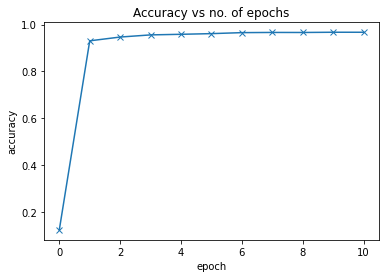

In [94]:
accuracies = [val_acc] + metrics1 + metrics2
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs no. of epochs')

ss
